In [179]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
from torchvision.utils import save_image
from tqdm.notebook import tqdm

# from IPython.display import Image

In [180]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
imsize = 224 if torch.cuda.is_available() else 128  # use small size if no gpu

In [181]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.chosen_features = ["0", "5", "10", "19", "28"]
        self.model = models.vgg19(pretrained=True).features[:29].eval() # pretrained model
    
    def forward(self, x):
        features = [] # list of features
        
        for layer_num, layer in enumerate(self.model):
            x = layer(x) # forward pass
            if str(layer_num) in self.chosen_features: # if layer is in chosen features
                features.append(x)
        
        return features

In [182]:
class RemoveAlphaChannel(object):
    def __call__(self, image):
        if image.mode == 'RGBA':
            image = image.convert('RGB')
        return image

class SoftClamp(nn.Module):
    def __call__(self, image):
        return (torch.tanh(3*image - 1.5) + 1)/2.0 
    
def load_image(file_path):
    image = Image.open(file_path) # PIL image
    image = loader(image).unsqueeze(0) # add the batch dimension
    print(image.shape)
    return image.to(device) # use GPU if available

def save_image(tensor, file_name):
    image = tensor.cpu().clone() # we clone the tensor to not do changes on it
    image = image.squeeze(0) # remove the fake batch dimension
    image = unloader(image) # convert tensor to PIL image
    image.save("images/generated/" + file_name)

def show_image(tensor):
    image = tensor.cpu().clone() # we clone the tensor to not do changes on it
    image = image.squeeze(0) # remove the fake batch dimension
    image = unloader(image) # convert tensor to PIL image
    display(image)

loader = transforms.Compose([
    RemoveAlphaChannel(),
    transforms.Resize((imsize, imsize)), # resize image
    transforms.ToTensor(), # convert image to Tensor
    # transforms.Normalize(mean=(0.485, 0.456, 0.406), 
    #                      std=(0.229, 0.224, 0.225)) # normalize image
])
unloader = transforms.Compose([
    # transforms.Normalize(mean=(-2.12, -2.04, -1.80),
    #                      std=(4.37, 4.46, 4.44)), # unnormalize image
    SoftClamp(), # clamp image
    transforms.ToPILImage() # convert Tensor to PIL Image
])

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


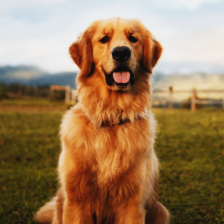

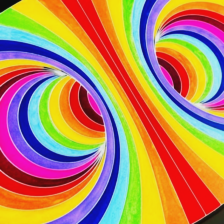

In [183]:
# load images
content_file = "images/content/dog.jpg"
style_file = "images/style/abstract6.jpg"

content_img = load_image(content_file) # 1x3 x img_size x img_size tensor
style_img = load_image(style_file) # 1x3 x img_size x img_size tensor

# generated = torch.randn(content_img.shape, device=device, requires_grad=True) # randomly initialize the image
generated_img = content_img.clone() 
# generated_img += 0.1*torch.randn(size=content_img.shape, requires_grad=False, device=device) #requires_grad(True) # randomly initialize the image
generated_img.requires_grad_(True)
show_image(content_img)
show_image(style_img)

In [187]:
# Hyperparameters
total_steps = 3000
lr = 0.0005
alpha = 1 # content loss
beta = 0.1 # style loss
optimizer = torch.optim.Adam([generated_img], lr=lr)

vgg = VGG().to(device) # pretrained VGG19 model

  0%|          | 0/3000 [00:00<?, ?it/s]

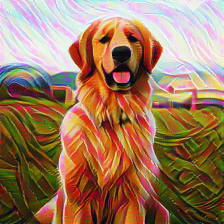

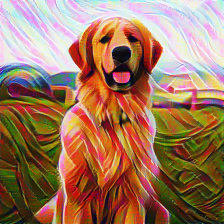

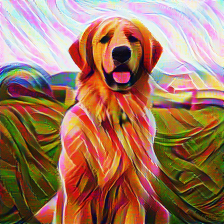

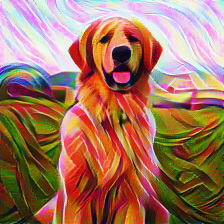

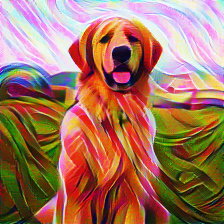

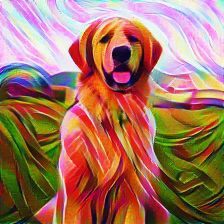

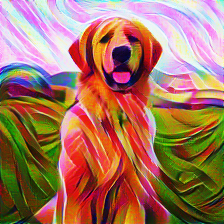

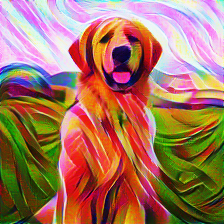

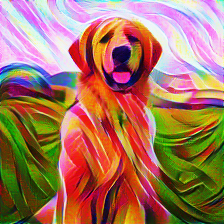

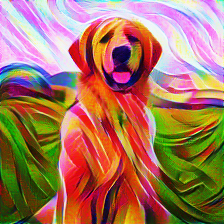

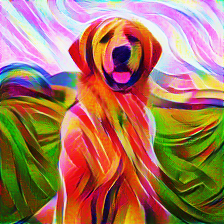

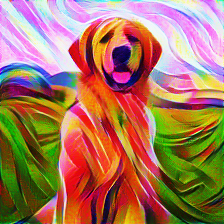

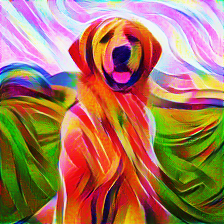

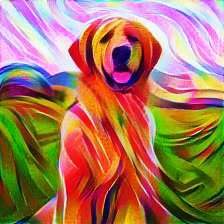

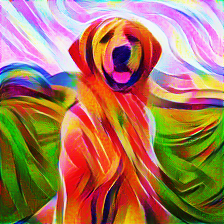

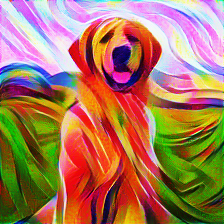

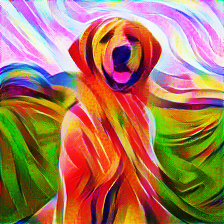

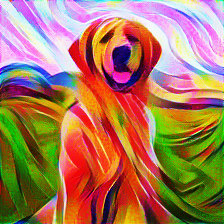

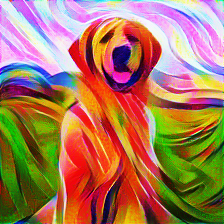

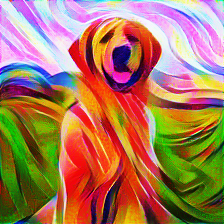

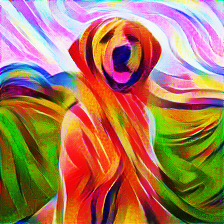

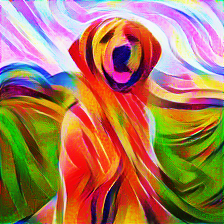

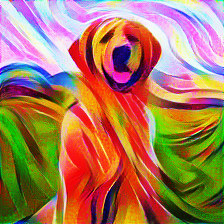

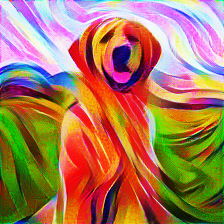

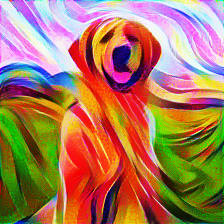

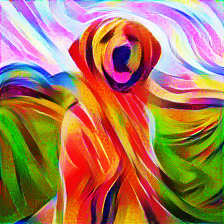

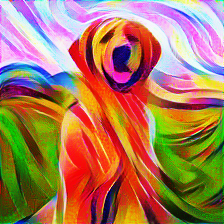

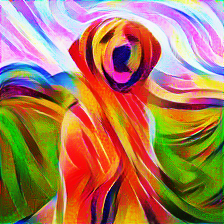

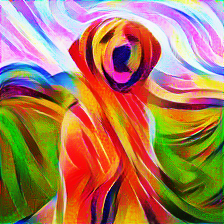

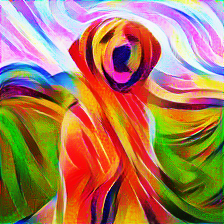

In [188]:
for step in tqdm(range(total_steps)):
    generated_imge_features = vgg(generated_img) # List of features of generated image (5 features)
    content_img_features = vgg(content_img)
    style_img_features = vgg(style_img)

    style_loss = content_loss = 0
    # Loop through all the features
    for gen_feature, content_feature, style_feature in zip(generated_imge_features, content_img_features, style_img_features):
        
        batch_size, channel, height, width = gen_feature.shape # batch_size = 1, each feature has different shape
        content_loss += torch.mean((gen_feature - content_feature)**2) # MSE

        # Compute Gram Matrix
        G = gen_feature.view(channel, height*width).mm(
            gen_feature.view(channel, height*width).t()
        )
        A = style_feature.view(channel, height*width).mm(
            style_feature.view(channel, height*width).t()
        )
        style_loss += torch.mean((G - A)**2)
    
    # # Add some loss is img is too bright or too dark
    # brigtness_loss = torch.mean(torch.log((generated))**2 + torch.log((1 - generated))**2)
    
    total_loss = alpha*content_loss + beta*style_loss #nn.MSELoss()(generated_imge_features[-1], style_img_features[-1])#
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 100 == 0:
        # print(total_loss.item())
        show_image(generated_img)

In [186]:
# Get the name of latest generated image
save_image(generated, "generated1.png")

NameError: name 'generated' is not defined